## Population Data
The goal of this code is to load the population dataset collected from FAO stats and process it in a way such that we can utilize it.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
population = pd.read_csv('./raw_data/fao_data_population.csv')
population.head(3)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,1950,1950,1000 persons,7752.118,X,International reliable sources,"UNDESA, Population Division – World Population..."
1,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,1951,1951,1000 persons,7840.156,X,International reliable sources,NaN
2,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,1952,1952,1000 persons,7935.997,X,International reliable sources,NaN


In [3]:
pd.unique(population['Unit'])

array(['1000 persons'], dtype=object)

We see that many of the columns are irrelevant as they contain the same information in all columns. This is Domain Code, Domain, Element, Element Code, Item Code, Item, Year Code (Same as Year) and Note.  
We actually have two Flags: A and X. X is regarded most reliable(_International reliable sources_), but we will also regard A (_Aggregate, may include official, semi-official, estimated or calculated data_) as reliable. Therefore we also remove these columns.

In [4]:
drop_col = ['Domain Code', 'Domain', 'Element Code', 'Element', 'Item Code', 'Item', 'Year Code', 'Flag', 'Flag Description', 'Note']
population.drop(drop_col, axis = 1, inplace = True)
population.head(5)


,Area Code,Area,Year,Unit,Value
0,2,Afghanistan,1950,1000 persons,7752.118
1,2,Afghanistan,1951,1000 persons,7840.156
2,2,Afghanistan,1952,1000 persons,7935.997
3,2,Afghanistan,1953,1000 persons,8039.694
4,2,Afghanistan,1954,1000 persons,8151.317


As we only have data in the other datasets from 1961 to 2013, we remove the extra years. 

In [5]:
population = population[(population['Year'] > 1960) & (population['Year'] <2014)]

**Categorizing the Data**  
We would like to divide our dataset into areas, countries and continents for easier use in the future. Luckily, because of the way area codes are organized, this is easily done. Everything under 251 is countries, and everything above 5000 are areas. 

In [6]:
from scripts.helpers import *
print(split_fao_data.__doc__)

pop_countries, pop_area, pop_continents = split_fao_data(population)


    Function that splits data into countries, areas and continents.
    params:
        df: fao-dataframe that includes area codes.
        
    returns:
        countries: dataframe with area-code < 500
        area: dataframe with only area-code > 500
        continents: dataframe with the 6 continents
    
    


**Saving the Data**  
To store the data for the future we save it in both CSV and pickles.  
All these CSV are however not pushed to git, so it has to be run locally. 

In [13]:
# Save dataframes to CSV
pop_countries.to_csv('./data/csv/pop_countries.csv')
pop_area.to_csv('./data/csv/pop_area.csv')
pop_continents.to_csv('./data/csv/pop_continents.csv')

In [14]:
# Save dataframes to pickles
pop_countries.to_pickle('./data/pickles/pop_countries.pkl')
pop_area.to_pickle('./data/pickles/pop_area.pkl')
pop_continents.to_pickle('./data/pickles/pop_continents.pkl')

#### First look at the data
To check if the data seems reasonable we plot the development in population for each continent.

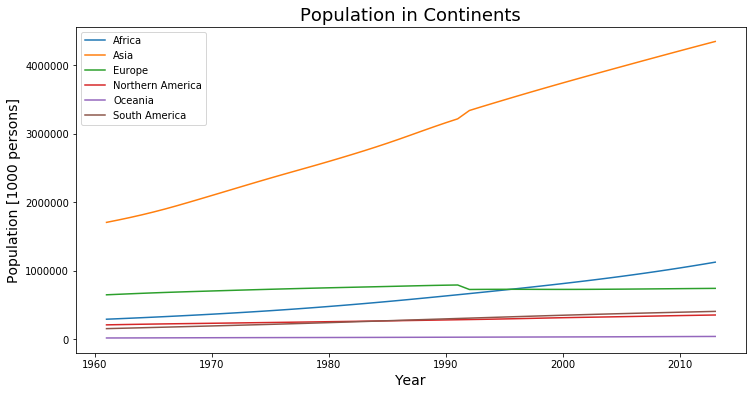

In [11]:
tmp = pop_continents.groupby(['Year', 'Area']).agg({'Value':'sum'}).reset_index()

f = plt.figure(figsize=(12, 6))

for area in tmp.Area.unique():
    y = tmp[tmp['Area'] == area].Value.values
    x = tmp[tmp['Area'] == area].Year.values
    plt.plot(x,y)
    
plt.legend(tmp.Area.unique())
plt.title('Population in Continents', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Population [1000 persons]', fontsize = 14)
plt.show()

The data looks reasonable at first glance, but we see that there is some wierd behaviour in Asia and Europe around 1990. To examine this we plot each of the continents seperately.

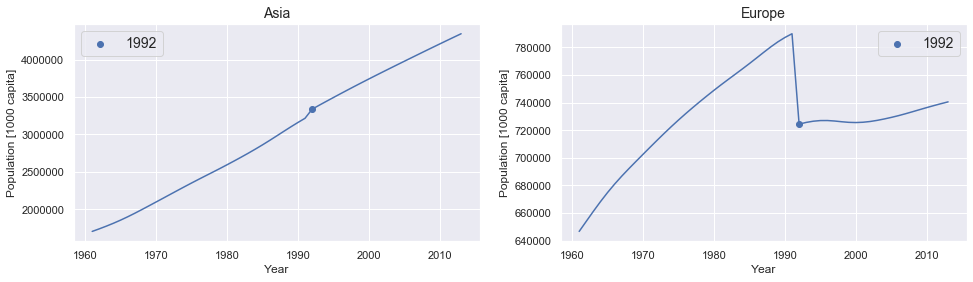

In [105]:
pop_europe_asia = pop_continents[(pop_continents['Area'] == 'Europe') | (pop_continents['Area'] == 'Asia')]
tmp = pop_europe_asia.groupby(['Year', 'Area']).agg({'Value':'sum'}).reset_index()

f = plt.figure(figsize=(16, 4))

for (ind, area) in zip(range(1,1 + tmp.Area.unique().shape[0]), tmp.Area.unique()):
    plt.subplot(1, 2, ind)
    y = tmp[tmp['Area'] == area].Value.values
    x = tmp[tmp['Area'] == area].Year.values
    plt.plot(x,y)
    plt.scatter(x = 1992, y = tmp[tmp['Year'] == 1992]['Value'].values[ind-1], label = '1992', color = 'b')
    plt.title(area, fontsize= 14)
    plt.xlabel('Year')
    plt.ylabel('Population [1000 capita]')
    plt.legend(fontsize = 14)
plt.show()

We see that we have a huge drop in the population in Europe in 1992, which coincides with the dissolution of the Soviet Union. What really happens is that some countries from the Soviet Union is now classified as Asia, and the relative difference in Asia is smaller than in Europe.   
There is no easy way to fix this, but luckily all other statistics are also handled in this way, so we use the dataset as it is.